#### Backgroud and Goal: 
- Use the provided data to explore 2 areas of modeling regarding sales. 
- Athough other areas of data science/machine learning/econometrics such as content-based recommender, market-mix modeling, deep learning can also be explored, this case study only covers sales forecasting and sales prediction.
- As Some companies might want to predict the sale for a product, and the potential driver of that sale, this notebook explore the machine learning and regression models for the purpose. (Cross-Sectional Regression and Machine Learning)
- Companies might also want to know forecasted overall sales and revenue in different granularity over time for planning purpose. The R script explores variaous Time-Series Forecasting models for the overall sales. (Aggregated Time-Series)


#### Import Library

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

# import scorecardpy as sc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import PolynomialFetures
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.core.display import HTML

%matplotlib inline

In [46]:
# Plot function
def resid_v_fitted(fitted_y, y, ax):
    """Plots the residuals v.s. fitted values"""
    sns.residplot(fitted_y, y,
                 lowess=True, scatter_kws={'alpha' : 0.5},
                 line_kws={'color' : 'red', 'lw' : 1, 'alpha' : 0.8}, ax=ax)
    
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted')
    ax.set_ylabel('Residuals')
    
def normal_QQ_plot(norm_residuals, ax):
    QQ = ProbPlot(norm_residuals)
    QQ.qqplot(line='45', alpha =0.5, color='#4C72B0', lw=1, ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized Residuals')
    abs_norm_resid = norm_residuals.sort_values(ascending=False)
    
def diagnostic_plots(model, X, y, return_high_leverage=False):
    fitted_y = model.fittedvalues
    residuals = model.resid
    norm_residuals = pd.Series(model.get_influence().resid_studentized_internal, index=fitted_y.index)
    norm_residuals_abs_sqrt = pd.Series(np.sqrt(np.abs(norm_residuals)), index=fitted_y.index)
    model_abs_resid = pd.Series(np.abs(residuals), index=fitted_y.index)
    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    # Residuals vs. Fitted
    resid_v_fitted(fitted_y, y, ax=ax[0])
    # Normal QQ Plot
    normal_QQ_plot(norm_residuals, ax=ax[1])

#### Read Data

In [3]:
sales = pd.read_csv('data_science_case/sales.txt', sep = ';')
sales.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0


In [4]:
article_attributes = pd.read_csv('data_science_case/article_attributes.txt', sep = ';')
article_attributes.head()

,article,productgroup,category,cost,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col
0,OC6355,SHOES,TRAINING,13.29,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255
1,AP5568,SHORTS,TRAINING,2.29,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255
2,CB8861,HARDWARE ACCESSORIES,GOLF,1.70,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255
3,LI3529,SHOES,RUNNING,9.00,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238
4,GG8661,SHOES,RELAX CASUAL,9.60,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238


#### Descriptive Analysis

In [5]:
# 81,426 rows, 9 columns
sales.shape

(81426, 9)

In [6]:
# No missing values, some object/categorical and some numerical
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81426 entries, 0 to 81425
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        81426 non-null  object 
 1   article        81426 non-null  object 
 2   sales          81426 non-null  int64  
 3   regular_price  81426 non-null  float64
 4   current_price  81426 non-null  float64
 5   ratio          81426 non-null  float64
 6   retailweek     81426 non-null  object 
 7   promo1         81426 non-null  int64  
 8   promo2         81426 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 5.6+ MB


In [7]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,81426.0,57.048375,88.506045,1.000000,10.000000,26.000000,65.000000,898.00
regular_price,81426.0,52.620695,35.549601,3.950000,25.950000,41.450000,79.950000,197.95
current_price,81426.0,28.356811,22.704746,1.950000,11.950000,20.950000,37.950000,197.95
ratio,81426.0,0.544464,0.192692,0.296482,0.354839,0.523526,0.697322,1.00
promo1,81426.0,0.065041,0.246599,0.000000,0.000000,0.000000,0.000000,1.00
promo2,81426.0,0.005060,0.070953,0.000000,0.000000,0.000000,0.000000,1.00


In [8]:
article_attributes.shape

(476, 13)

In [9]:
article_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   article         476 non-null    object 
 1   productgroup    476 non-null    object 
 2   category        476 non-null    object 
 3   cost            476 non-null    float64
 4   style           476 non-null    object 
 5   sizes           476 non-null    object 
 6   gender          476 non-null    object 
 7   rgb_r_main_col  476 non-null    int64  
 8   rgb_g_main_col  476 non-null    int64  
 9   rgb_b_main_col  476 non-null    int64  
 10  rgb_r_sec_col   476 non-null    int64  
 11  rgb_g_sec_col   476 non-null    int64  
 12  rgb_b_sec_col   476 non-null    int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 48.5+ KB


In [10]:
article_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
cost,476.0,5.177920,3.362820,0.4,2.60,4.25,7.9,19.8
rgb_r_main_col,476.0,161.201681,72.918738,0.0,122.00,180.00,214.0,255.0
rgb_g_main_col,476.0,156.184874,60.579756,10.0,120.25,155.00,205.0,255.0
rgb_b_main_col,476.0,143.237395,71.061399,0.0,97.00,143.00,205.0,255.0
rgb_r_sec_col,476.0,158.647059,77.208463,0.0,113.00,176.50,218.5,255.0
rgb_g_sec_col,476.0,157.634454,62.054618,10.0,127.00,155.00,205.0,255.0
rgb_b_sec_col,476.0,142.008403,73.808771,0.0,91.50,139.00,205.0,255.0


In [11]:
# Merge the two datasets together, 123 missing attributes
data = pd.merge(sales, article_attributes, on = 'article', how = 'left')

data.isnull().sum()

country             0
article             0
sales               0
regular_price       0
current_price       0
ratio               0
retailweek          0
promo1              0
promo2              0
productgroup      123
category          123
cost              123
style             123
sizes             123
gender            123
rgb_r_main_col    123
rgb_g_main_col    123
rgb_b_main_col    123
rgb_r_sec_col     123
rgb_g_sec_col     123
rgb_b_sec_col     123
dtype: int64

In [12]:
# It seems that article 'IO7646' does not have valid attribute info, not many, will drop it for now
data[data.productgroup.isna()].article.unique()

array(['IO7646'], dtype=object)

In [13]:
data.dropna(inplace=True)

#### Explorative Analysis

In [14]:
cat = data.select_dtypes(include='object').columns
num = data.select_dtypes(exclude='object').columns

<AxesSubplot:>

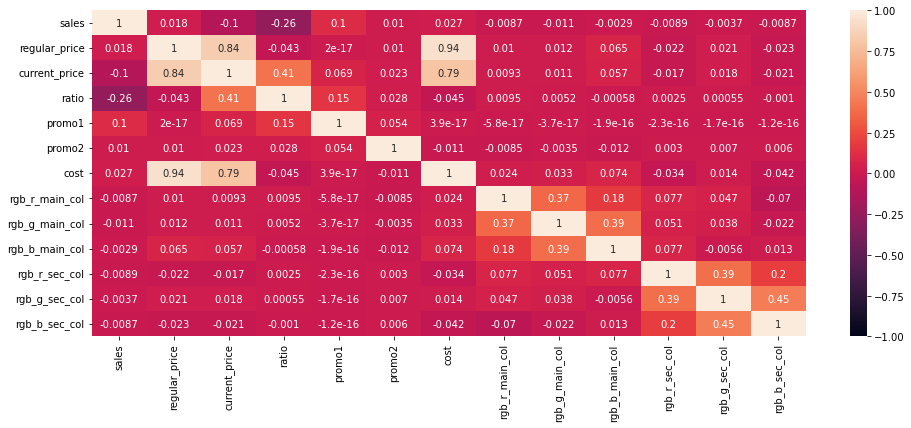

In [15]:
# For numerical factors, sales seem not heavily correlated with the facotrs except for the discount ratio, current price and promo1.
plt.figure(figsize = (16, 6))
sns.heatmap(data[num].corr(), vmin=-1, vmax=1, annot=True)

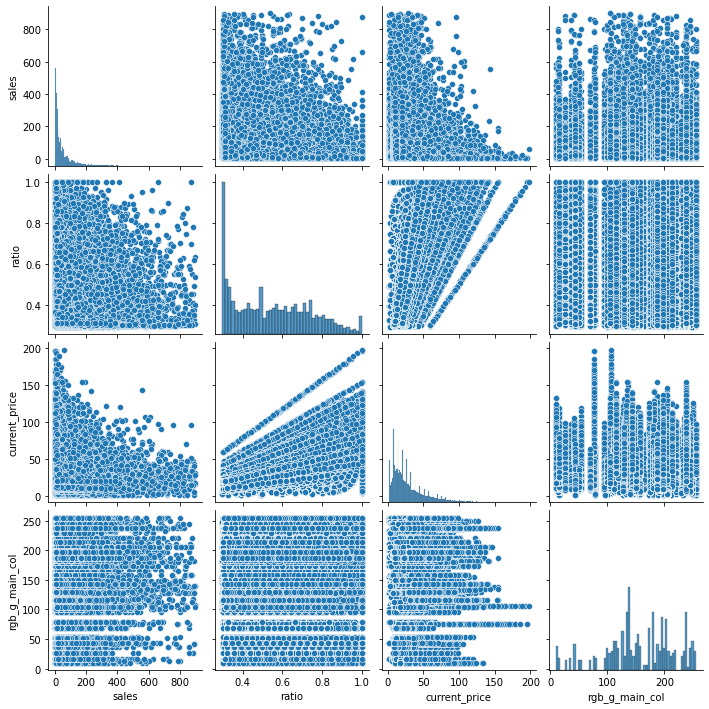

In [16]:
# Pairplot for some numerical variables, no clear linear relationship
sns.pairplot(data[['sales', 'ratio', 'current_price', 'rgb_g_main_col']])

In [17]:
# Explore some categorical variables, retailweek is a datetime, need to modify it later
# Some categories have too many factors, need to feature engineering them as well
cardinal = {}

for i in cat.drop('article'):
    cardinal[i] = data[i].nunique()

cardinal

{'country': 3,
 'retailweek': 123,
 'productgroup': 6,
 'category': 21,
 'style': 3,
 'sizes': 8,
 'gender': 4}

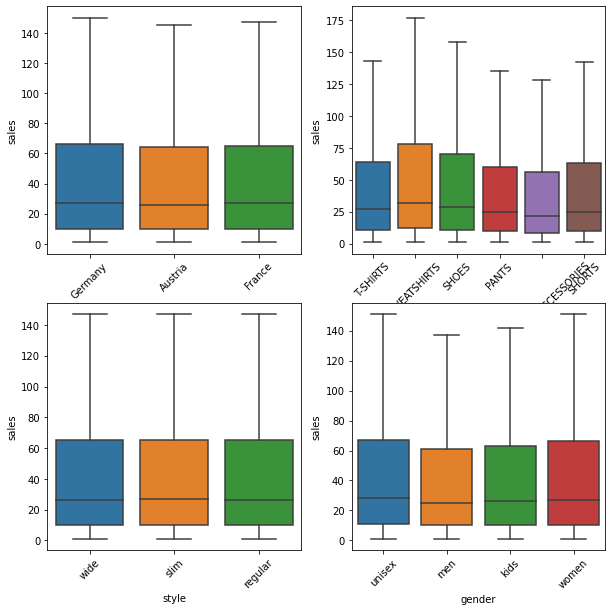

In [18]:
# Some whisker plots to look at, some differences in product group and gender
fig, axs = plt.subplots(2, 2, figsize = (10, 10))
for ax, i in zip(axs.flat, ['country', 'productgroup', 'style', 'gender']):
    sns.boxplot(x=i, y="sales", data=data, showfliers=False, ax = ax)
    ax.tick_params(axis='x', rotation=45)


#### Feature Engineering

In [19]:
var_to_drop = ['article']

In [20]:
# Change the retailweek to datetime and extract year, month and day of year from it, there could be seasonality/holiday in the sales data
data['retailweek'] = pd.to_datetime(data.retailweek)
data['year'] = data.retailweek.dt.year
data['month'] = data.retailweek.dt.month
data['day_of_year'] = data.retailweek.dt.day_of_year

var_to_drop += ['retailweek']

<AxesSubplot:xlabel='month', ylabel='sales'>

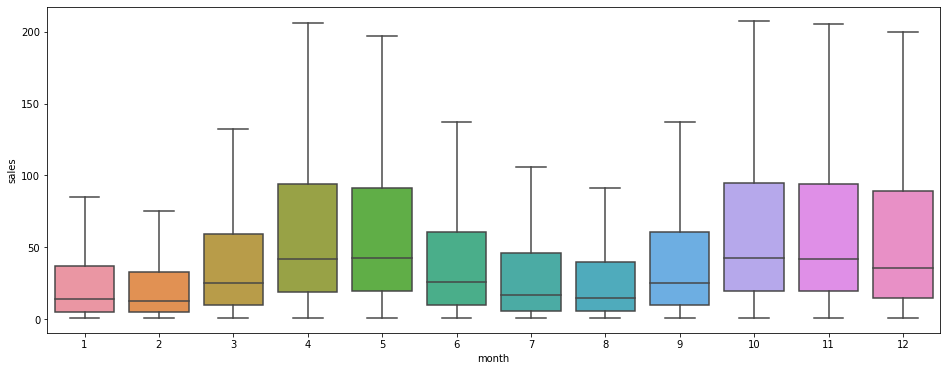

In [21]:
# April, May, and later in the year usually have higher sales
plt.figure(figsize = (16, 6))
sns.boxplot(x='month', y="sales", data=data, showfliers=False)

In [22]:
# Category has too many factors, need to merge them or classify them into others
data['category'].value_counts()

TRAINING              26937
RUNNING               17712
FOOTBALL GENERIC      10947
FOOTBALL LICENSED      5781
OUTDOOR                5658
TENNIS                 3198
INDOOR                 2952
SWIM                   2706
GOLF                   1722
ORIGINALS               615
BASKETBALL GENERIC      615
RELAX CASUAL            615
NEO                     369
DRESS CASUAL            246
PORSCHE                 246
ACTIVE CASUAL           246
ACTION SPORTS           246
CLASSICS                123
STELLA                  123
SLVR                    123
OLYMPICS                123
Name: category, dtype: int64

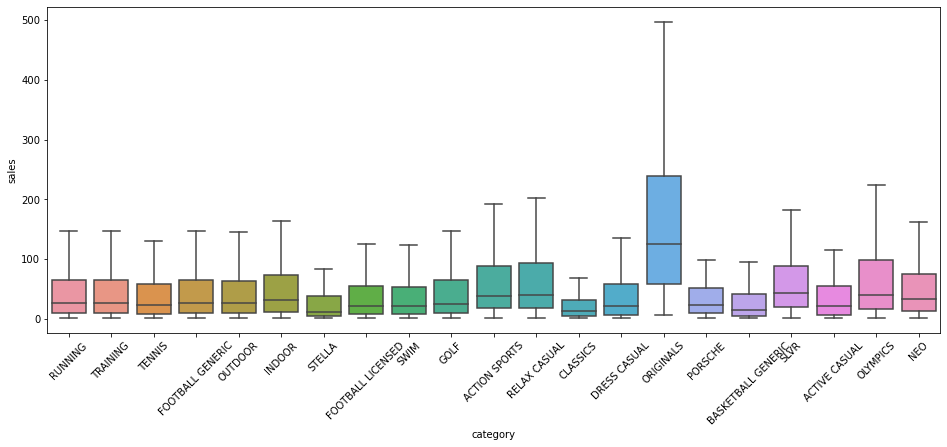

In [23]:
plt.figure(figsize = (16, 6))
sns.boxplot(x='category', y="sales", data=data, showfliers=False)
plt.xticks(rotation=45)
plt.show()

In [24]:
# Casuals all merge into one
data['category'] = data.category.replace(['RELAX CASUAL', 'DRESS CASUAL', 'ACTIVE CASUAL'], 'CASUAL')

# Football all merge into one, this might lose some info, but let's do it for this case
data['category'] = data.category.replace(['FOOTBALL GENERIC', 'FOOTBALL LICENSED'], 'FOOTBALL')

# Keep Training and Running as they are many, keep the originals as it's interesting to check, and merge others into one group
data['category'] = np.where(data.category.isin(['TRAINING', 'RUNNING', 'CASUAL', 'FOOTBALL', 'ORIGINALS']), data.category, 'OTHERS')


In [25]:
data['category'].value_counts()

TRAINING     26937
OTHERS       18204
RUNNING      17712
FOOTBALL     16728
CASUAL        1107
ORIGINALS      615
Name: category, dtype: int64

In [26]:
# Change sizes to a numerical value mesuring the number of options
data['num_of_sizes'] = data.sizes.str.split(',').apply(lambda x: len(x))

var_to_drop += ['sizes']

In [27]:
data.num_of_sizes.value_counts()

7    49200
5    14637
4     9348
6     8118
Name: num_of_sizes, dtype: int64

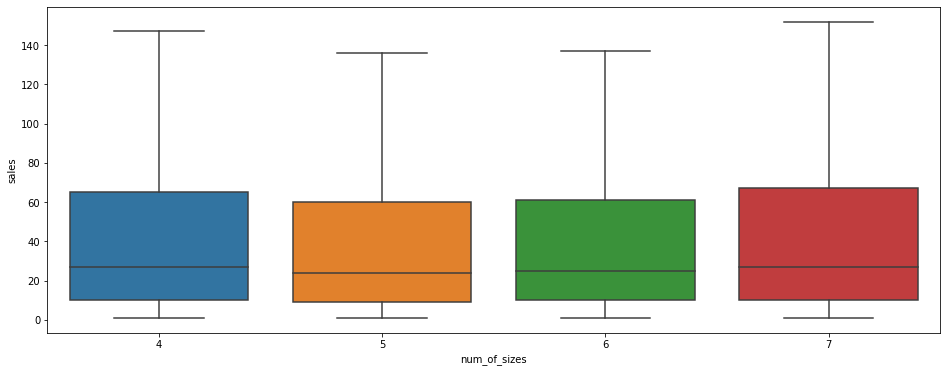

In [28]:
plt.figure(figsize = (16, 6))
sns.boxplot(x='num_of_sizes', y="sales", data=data, showfliers=False)
plt.show()

In [29]:
# Dropout the variables that no longer needed
data.drop(var_to_drop, axis = 1, inplace=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81303 entries, 0 to 81425
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         81303 non-null  object 
 1   sales           81303 non-null  int64  
 2   regular_price   81303 non-null  float64
 3   current_price   81303 non-null  float64
 4   ratio           81303 non-null  float64
 5   promo1          81303 non-null  int64  
 6   promo2          81303 non-null  int64  
 7   productgroup    81303 non-null  object 
 8   category        81303 non-null  object 
 9   cost            81303 non-null  float64
 10  style           81303 non-null  object 
 11  gender          81303 non-null  object 
 12  rgb_r_main_col  81303 non-null  float64
 13  rgb_g_main_col  81303 non-null  float64
 14  rgb_b_main_col  81303 non-null  float64
 15  rgb_r_sec_col   81303 non-null  float64
 16  rgb_g_sec_col   81303 non-null  float64
 17  rgb_b_sec_col   81303 non-null 

In [31]:
# Change variable types
data['month'] = data.month.astype('object')

#### Preliminary Univariate Variable Selection

In [32]:
# This is used to filter out the variables that are not significant
# R^2, Adj R^2, P-Value, AIC, BIC for each variable
cols = ['R^2', 'Adj R^2', 'P-Value', 'AIC', 'BIC']
rows = []
variable_selection_metrics = pd.DataFrame(rows, columns = cols)

for i in data.columns.drop('sales'):
    results = smf.ols(formula = 'sales ~ {}'.format(i), data = data).fit()
    variable_selection_metrics.loc[i, 'R^2'] = results.rsquared
    variable_selection_metrics.loc[i, 'Adj R^2'] = results.rsquared_adj
    variable_selection_metrics.loc[i, 'P-Value'] = results.pvalues[1]
    variable_selection_metrics.loc[i, 'AIC'] = results.aic
    variable_selection_metrics.loc[i, 'BIC'] = results.bic

variable_selection_metrics.sort_values('P-Value')


,R^2,Adj R^2,P-Value,AIC,BIC
ratio,0.066292,0.066281,0.0,954213.343092,954231.954968
day_of_year,0.013149,0.013137,0.0,958713.889947,958732.501823
promo1,0.010665,0.010653,0.0,958918.329031,958936.940907
current_price,0.010408,0.010396,0.0,958939.448949,958958.060825
year,0.001177,0.001165,0.0,959694.316642,959712.928519
cost,0.000747,0.000735,0.0,959729.287307,959747.899184
num_of_sizes,0.0004,0.000387,0.0,959757.575066,959776.186942
category,0.015511,0.015451,0.0,958527.076356,958582.911985
regular_price,0.000339,0.000326,0.0,959762.53686,959781.148736
month,0.042024,0.041894,0.000256,956319.509449,956431.180707


In [33]:
# Drop out features that have P-Values larger than 5%
insig_var = variable_selection_metrics[variable_selection_metrics['P-Value'] > 0.05].index

data.drop(insig_var, axis = 1, inplace=True)

In [34]:
data.columns

Index(['country', 'sales', 'regular_price', 'current_price', 'ratio', 'promo1',
       'promo2', 'productgroup', 'category', 'cost', 'rgb_r_main_col',
       'rgb_g_main_col', 'rgb_r_sec_col', 'rgb_b_sec_col', 'year', 'month',
       'day_of_year', 'num_of_sizes'],
      dtype='object')

#### Preprocessing

In [35]:
# Updating the categorical and numerical features
cat = data.select_dtypes(include='object').columns
num = data.select_dtypes(exclude='object').columns
num = num.drop('sales')

In [36]:
# Encode the categorical features into dummies
encoder = OneHotEncoder(drop = 'first')
encoder.fit_transform(data[cat]).toarray()

data[encoder.get_feature_names(cat)] = encoder.fit_transform(data[cat]).toarray()

In [37]:
# Standardize the numerical features, split the data into train and test first
# We don't need to standardize the data for OLS and tree-based models, and model will be more interpretable if we don't standardize it.
# But below code can be uncommented if we need to standardize in some cases and models
x = data.drop('sales', axis = 1)

y = data['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=1)

# x_train_t = x_train.copy()
# x_test_t = x_test.copy()

# normalizer = StandardScaler()
# x_train_t[num.drop(['promo1', 'promo2'])] = normalizer.fit_transform(x_train[num.drop(['sales', 'promo1', 'promo2'])])
# x_test_t[num.drop(['promo1', 'promo2'])] = normalizer.transform(x_test[num.drop(['sales', 'promo1', 'promo2'])])

#### OLS Models

In [38]:
# Stepwise feature selection, parsimounious.
# It seems only a few variables are significant.
x_fs = x_train.drop(cat, axis = 1)

sffs = SFS(LinearRegression(fit_intercept = True), 
          k_features = 'parsimonious',
          forward = True,
          floating = True,
          scoring = 'r2',
          cv = 5).fit(x_fs, y_train)

print(sffs.k_feature_names_)
print(sffs.k_score_)

('current_price', 'ratio', 'promo1', 'num_of_sizes', 'productgroup_SHOES', 'productgroup_SWEATSHIRTS', 'category_ORIGINALS')
0.10386275424991101


In [39]:
# K-fold Cross Validation for evaluation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [40]:
# Model is too big, and some insignificant variables
# Also, Sales cannot be negative, might need to use log model
model_1 = smf.ols(formula = 'sales ~ ' + '+'.join(x_train[list(cat) + list(num)].columns), data = pd.concat([x_train, y_train], axis = 1)).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     240.2
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:38:14   Log-Likelihood:            -4.2790e+05
No. Observations:               73172   AIC:                         8.559e+05
Df Residuals:                   73135   BIC:                         8.562e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [41]:
# Validation scores are around 10%.
x_cv = x_train.drop(cat, axis = 1)
y_cv = y_train

#model_1_cv = LinearRegression(fit_intercept = False)
#scores_1 = cross_val_score(model_1_cv, sm.add_constant(x_cv), y_cv, scoring = 'r2', cv = folds)
model_1_cv = LinearRegression(fit_intercept = True)
scores_1 = cross_val_score(model_1_cv, x_cv, y_cv, scoring = 'r2', cv = folds)


scores_1

array([0.10522689, 0.10031781, 0.10813917, 0.10179481, 0.10746046])

In [42]:
# VIF test, high VIF for some variables, need to drop
x_1 = x_train.drop(cat, axis = 1)
vif = pd.DataFrame()
vif['feature'] = x_1.columns
vif['VIF'] = [variance_inflation_factor(x_1.values, i) for i in range(len(x_1.columns))]
vif

,feature,VIF
0,regular_price,62.857954
1,current_price,28.277186
2,ratio,41.372566
3,promo1,1.422481
4,promo2,1.050800
5,cost,44.553102
6,rgb_r_main_col,7.257024
7,rgb_g_main_col,9.101360
8,rgb_r_sec_col,5.631764
9,rgb_b_sec_col,4.930816


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


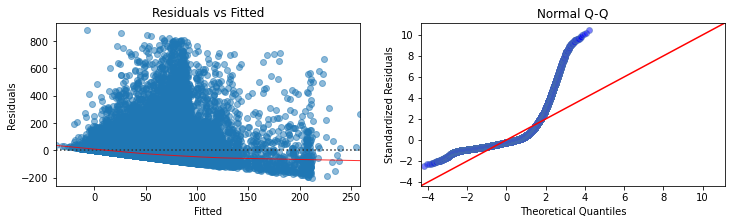

In [47]:
# Residual Plot Check
# Non-nomral random residual, ok if data is large.
diagnostic_plots(model_1, x_cv, y_cv)

In [48]:
# Model is more parsimonious, and all the variables are significant
model_2 = smf.ols(formula = 'sales ~ ' + '+'.join(sffs.k_feature_names_), data = pd.concat([x_train, y_train], axis = 1)).fit()

print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     1214.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:50:59   Log-Likelihood:            -4.2797e+05
No. Observations:               73172   AIC:                         8.560e+05
Df Residuals:                   73164   BIC:                         8.560e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [49]:
# Validation scores are around 10%.
x_cv = x_train[list(sffs.k_feature_names_)]
y_cv = y_train

#model_2_cv = LinearRegression(fit_intercept = False)
#scores_2 = cross_val_score(model_2_cv, sm.add_constant(x_cv), y_cv, scoring = 'r2', cv = folds)
model_2_cv = LinearRegression(fit_intercept = True)
scores_2 = cross_val_score(model_2_cv, x_cv, y_cv, scoring = 'r2', cv = folds)


scores_2

array([0.10423117, 0.09953705, 0.10726703, 0.10126188, 0.10681359])

In [50]:
# VIF test, low VIF
x_2 = x_train[list(sffs.k_feature_names_)]
vif = pd.DataFrame()
vif['feature'] = x_2.columns
vif['VIF'] = [variance_inflation_factor(x_2.values, i) for i in range(len(x_2.columns))]
vif

,feature,VIF
0,current_price,6.040402
1,ratio,10.807642
2,promo1,1.093469
3,num_of_sizes,8.351121
4,productgroup_SHOES,3.370871
5,productgroup_SWEATSHIRTS,1.160229
6,category_ORIGINALS,1.027845


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


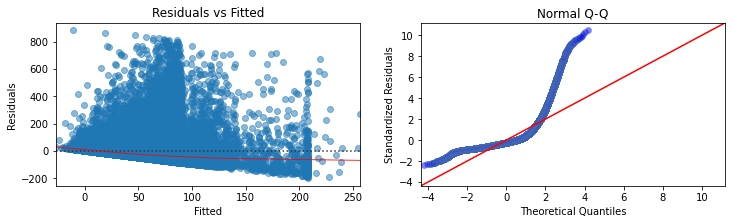

In [53]:
# Residual Plot Check
# Non-nomral random residual, ok if data is large.
diagnostic_plots(model_2, x_cv, y_cv)

#### Decision Tree Model

In [240]:
# Some variables might have non-linear relationship with sales, so try tree-based models
x_tree = x_train.drop(cat, axis = 1)
y_tree = y_train

# define models and parameters
model = tree.DecisionTreeRegressor()


grid = {
# "splitter":["best","random"],
"max_depth" : [2,4,6,8,10,12],
# "criterion" : ['gini', 'entropy'],
# "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
# "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
# "max_features":["auto","log2","sqrt",None],
"max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]
}

# define grid search
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring='r2', error_score=0)
grid_result = grid_search.fit(x_tree, y_tree)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.101909 using {'max_depth': 4, 'max_leaf_nodes': 10}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': None}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 10}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 20}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 30}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 40}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 50}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 60}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 70}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 80}
0.074412 (0.005332) with: {'max_depth': 2, 'max_leaf_nodes': 90}
0.100074 (0.004698) with: {'max_depth': 4, 'max_leaf_nodes': None}
0.101909 (0.003454) with: {'max_depth': 4, 'max_leaf_nodes': 10}
0.100074 (0.004698) with: {'max_depth': 4, 'max_leaf_nodes': 20}
0.100074 (0.004698) with: {'max_depth': 4, 'max_leaf_nodes': 30}
0.100074 (0.004698) with: 

In [241]:
model_3 = tree.DecisionTreeRegressor(max_depth = 4, max_leaf_nodes = 10).fit(x_tree, y_tree)

scores_3 = cross_val_score(model_3, x_tree, y_tree, scoring = 'r2', cv = folds)

scores_3

array([0.10113518, 0.09858459, 0.10143045, 0.09987702, 0.10851638])

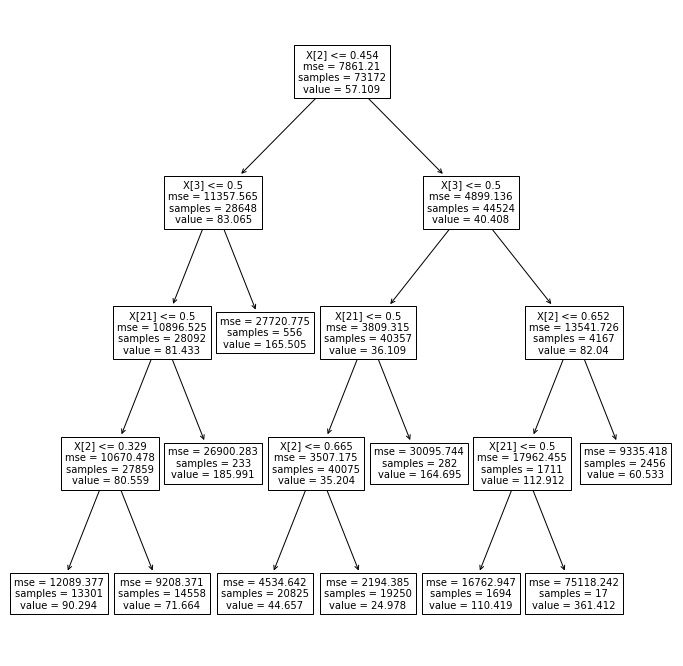

In [242]:
plt.figure(figsize = (12, 12))
tree.plot_tree(model_3, fontsize = 10)
plt.show()

In [243]:
tree.export_text(model_3)

'|--- feature_2 <= 0.45\n|   |--- feature_3 <= 0.50\n|   |   |--- feature_21 <= 0.50\n|   |   |   |--- feature_2 <= 0.33\n|   |   |   |   |--- value: [90.29]\n|   |   |   |--- feature_2 >  0.33\n|   |   |   |   |--- value: [71.66]\n|   |   |--- feature_21 >  0.50\n|   |   |   |--- value: [185.99]\n|   |--- feature_3 >  0.50\n|   |   |--- value: [165.51]\n|--- feature_2 >  0.45\n|   |--- feature_3 <= 0.50\n|   |   |--- feature_21 <= 0.50\n|   |   |   |--- feature_2 <= 0.67\n|   |   |   |   |--- value: [44.66]\n|   |   |   |--- feature_2 >  0.67\n|   |   |   |   |--- value: [24.98]\n|   |   |--- feature_21 >  0.50\n|   |   |   |--- value: [164.70]\n|   |--- feature_3 >  0.50\n|   |   |--- feature_2 <= 0.65\n|   |   |   |--- feature_21 <= 0.50\n|   |   |   |   |--- value: [110.42]\n|   |   |   |--- feature_21 >  0.50\n|   |   |   |   |--- value: [361.41]\n|   |   |--- feature_2 >  0.65\n|   |   |   |--- value: [60.53]\n'

Text(0, 0.5, 'Feature Importance Score')

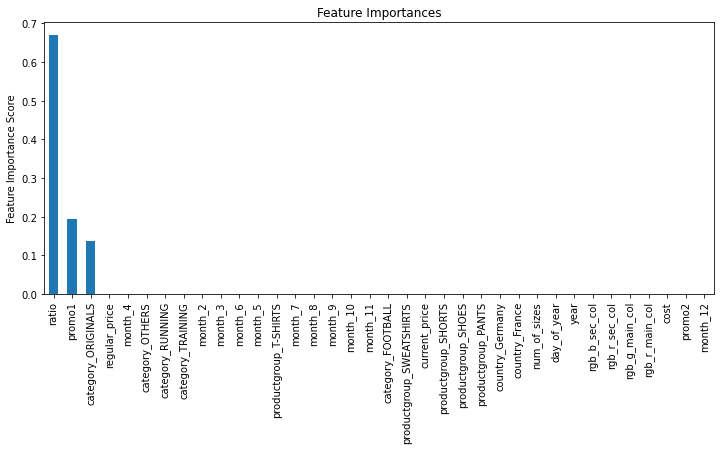

In [244]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_3.feature_importances_, x_tree.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title = 'Feature Importances')
plt.ylabel('Feature Importance Score')

#### Gradient Boosting

In [251]:
# define models and parameters
model = GradientBoostingRegressor()
grid = {
# 'n_estimators' : [10, 100, 250],
'learning_rate' : [0.001, 0.01, 0.1],
# 'subsample' : [0.5, 0.7, 1.0],
'max_depth' : [3, 7, 9]
}

# define grid search
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring = 'r2', error_score = 0)
grid_result = grid_search.fit(x_tree, y_tree)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.156410 using {'learning_rate': 0.1, 'max_depth': 7}
0.016836 (0.000504) with: {'learning_rate': 0.001, 'max_depth': 3}
0.020535 (0.000597) with: {'learning_rate': 0.001, 'max_depth': 7}
0.021810 (0.000593) with: {'learning_rate': 0.001, 'max_depth': 9}
0.086890 (0.002091) with: {'learning_rate': 0.01, 'max_depth': 3}
0.095449 (0.001677) with: {'learning_rate': 0.01, 'max_depth': 7}
0.097842 (0.001850) with: {'learning_rate': 0.01, 'max_depth': 9}
0.132096 (0.003004) with: {'learning_rate': 0.1, 'max_depth': 3}
0.156410 (0.004581) with: {'learning_rate': 0.1, 'max_depth': 7}
0.135503 (0.004130) with: {'learning_rate': 0.1, 'max_depth': 9}


In [269]:
model_4 = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 7).fit(x_tree, y_tree)

scores_4 = cross_val_score(model_4, x_tree, y_tree, scoring = 'r2', cv = folds)

scores_4

array([0.1594963 , 0.15542455, 0.16147855, 0.15317778, 0.15274065])

Text(0, 0.5, 'Feature Importance Score')

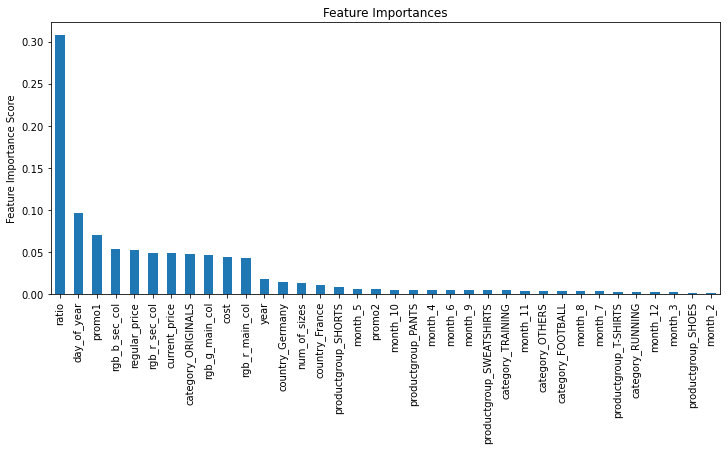

In [270]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_4.feature_importances_, x_tree.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Metrics on Training, Validation and Test Data

In [312]:
# The best model would be model_4, although it might be overfitting, need some regularizaiton
models = ['model_1', 'model_2', 'model_3', 'model_4']

cv_R2 = [round(scores_1.mean(), 2), round(scores_2.mean(), 2), 
         round(scores_3.mean(), 2), round(scores_4.mean(), 2)]

In_Sample_R2 = [round(metrics.r2_score(y_train, list(map(round, model_1.predict()))), 2), 
                round(metrics.r2_score(y_train, list(map(round, model_2.predict()))), 2), 
                round(model_3.score(x_tree, y_tree), 2), 
                round(model_4.score(x_tree, y_tree), 2)]

test_RMSE = [round(np.sqrt(metrics.mean_absolute_error(y_test, list(map(round, model_1.predict(x_test[list(cat) + list(num)]))))), 2), 
             round(np.sqrt(metrics.mean_absolute_error(y_test, list(map(round, model_2.predict(x_test[list(sffs.k_feature_names_)]))))), 2), 
             round(np.sqrt(metrics.mean_absolute_error(y_test, model_3.predict(x_test.drop(cat, axis = 1)))), 2), 
             round(np.sqrt(metrics.mean_absolute_error(y_test, model_4.predict(x_test.drop(cat, axis = 1)))), 2)]

dict_metrics = {'Models' : models, 'In Sample R2' : In_Sample_R2, 
                'Cross Validation R2' : cv_R2, 'Test Root Mean Squared Error' : test_RMSE}

pd.DataFrame(dict_metrics)

,Models,In Sample R2,Cross Validation R2,Test Root Mean Squared Error
0,model_1,0.11,0.10,6.99
1,model_2,0.10,0.10,6.99
2,model_3,0.11,0.10,6.98
3,model_4,0.32,0.16,6.72
